In [1]:
import os
import cv2
import numpy as np
import torch
from tqdm import tqdm

In [4]:

REBUILD_DATA = False # set to true to one once, then back to false unless you want to change something in your training data.

class Dice():
    IMG_SIZE = 50
    TRAINING_DIR = "realTrain"
    SAMPLES_NUM = 100  # set so that there is an equal amount of every class

    training_data = []

    counter = [0 for i in range(6)]
    

    def make_training_data(self):
        for f in tqdm(os.listdir(self.TRAINING_DIR)):
            if "jpg" in f:
#                 print(f)
                path = os.path.join(self.TRAINING_DIR, f)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                cv2.imwrite(os.path.join("scaled", f), img)
                c = int(f[len(f) - 5]) - 1
                if self.counter[c] < self.SAMPLES_NUM:
                    ans = np.eye(6)[c]
                    self.training_data.append([np.array(img), ans])
                    self.counter[c] += 1


        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        for ind, value in enumerate(self.counter):
            print(ind, value)


if REBUILD_DATA:
    dice = Dice()
    dice.make_training_data()


training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))
print(training_data[0])

100%|██████████| 243/243 [00:00<00:00, 344.71it/s]


0 43
1 34
2 45
3 37
4 43
5 41
243
[array([[ 69,  73,  73, ..., 162, 155, 152],
        [ 67,  70,  73, ..., 158, 154, 151],
        [ 78,  68,  70, ...,  75, 151, 148],
        ...,
        [ 80,  77,  77, ..., 101,  99, 100],
        [ 74,  79,  76, ...,  99, 103, 105],
        [ 67, 131,  76, ..., 100, 102, 106]], dtype=uint8)
 array([0., 0., 0., 0., 1., 0.])]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 64, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(64, 128, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(128, 256, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 6) # 512 in, 6 out bc we're doing 6 classes (dice)

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = torch.load("finalNet.pt")
net

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [4]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 1, 50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

166


/tmp/ipykernel_12698/607857972.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811723911/work/torch/csrc/utils/tensor_new.cpp:201.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1, 1, 50,50)


In [5]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 166/166 [00:00<00:00, 456.05it/s]

Accuracy:  0.789


In [6]:
img = cv2.imread("realTest.jpg", cv2.IMREAD_GRAYSCALE)
height, width = img.shape
img = img[height // 2 - 100:height // 2 + 100, width // 2 - 100:width // 2 + 100]
img = np.array(cv2.resize(img, (50, 50)))

In [3]:
IMG_DIR = "realTest"
IMG_SIZE = 50

counter = [0 for i in range(7)]
for f in tqdm(os.listdir(IMG_DIR)):
    path = os.path.join(IMG_DIR, f)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    try:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#         cv2.imwrite(os.path.join("realScaled", f), img)
        res = net(torch.from_numpy(img).view(-1,1,50,50) / 255.0)
        counter[torch.argmax(res).item()] += 1
    except Exception as e:
        print(e, end=' ')
#     print(f)
#     print(res)
#     print("\n")

 45%|████▌     | 249/548 [00:23<00:25, 11.89it/s]

OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
 

 89%|████████▉ | 488/548 [00:46<00:05, 11.92it/s]

OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
 

100%|██████████| 548/548 [00:52<00:00, 10.49it/s]


In [4]:
import matplotlib.pyplot as plt
import numpy as np

counter.pop(-1)
y = np.array(counter)

In [5]:
import pygal
bar_chart = pygal.Bar(height=1500, width=1500)
bar_chart.title = 'Dice rolls'
bar_chart.x_labels = map(str, range(1, 7))
bar_chart.add('Dice', y)
bar_chart.render_to_png('dice_stats.png')

# train_chart = pygal.Bar(height = 1500, width=1500)
# train_chart.title = 'Dice rolls'
# train_chart.x_labels = map(str, range(1, 7))
# train_chart.add('Dice', counter2)
# train_chart.render_to_png('train_chart.png')

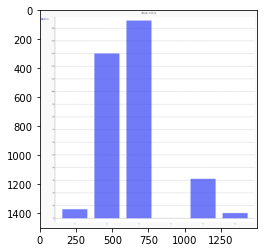

In [19]:
img = cv2.imread('dice_stats.png')
plt.imshow(img)

In [26]:
counter

[81, 56, 54, 68, 89, 57]

In [9]:
s = sum(counter)

In [16]:
p1 = [s/6 for i in range(6)]

In [17]:
xsq = sum((((counter[i] - p1[i]) ** 2) / p1[i] for i in range(6)))

In [18]:
xsq

9.852713178294575